## Training NPE with Uniform vs TailedUniform proposals on 2D Gaussian-Linear task

This notebook trains neural posterior estimators (NPE) to compare performance between standard Uniform and TailedUniform proposal distributions.

In [11]:
import numpy as np
import torch
import random

SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)

In [12]:
from toolbox.imports import *
from toolbox.distributions import TailedUniform, IndependentTailedUniform
from toolbox.simulators import sample_uniform_lhs

# Device configuration
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device:', device)

sns.set(style="whitegrid", context="paper", font_scale=1.2)

Device: cpu


### Generate training data from both proposal distributions

Sample parameters from Uniform and TailedUniform (σ=0.1×width) using LHS, then run forward simulator to generate observations.

In [13]:
n_simulations = 4000

# Parameters ranges
param_1_range = (-1.0, 1.0)
param_2_range = (-1.0, 1.0)
param_ranges = [param_1_range, param_2_range]

param_1_width = param_1_range[1] - param_1_range[0]
param_2_width = param_2_range[1] - param_2_range[0]

# Scale sigma relative to parameter ranges
sigma_scale = 0.1
sigmas = [sigma_scale * (high - low) for low, high in param_ranges]

# Task setup
task = GaussianLinear(
    dim=2, prior_scale=param_1_width/2
)
simulator = task.get_simulator()

# Prior and posterior
prior = ili.utils.IndependentNormal(
    loc = [param_1_width/2, param_2_width/2],
    scale = sigmas, device=device)

# Create the old proposal distribution
# Using Uniform distribution for the old proposal
proposal_old = ili.utils.Uniform(
    low=[param_1_range[0], param_2_range[0]], 
    high=[param_1_range[1], param_2_range[1]], 
    device=device)

# Create the TailedUniform distribution
proposal_new = TailedUniform(
    a = torch.tensor([param_1_range[0], param_2_range[0]], dtype=torch.float32),
    b = torch.tensor([param_1_range[1], param_2_range[1]], dtype=torch.float32),
    sigma = torch.tensor([sigmas[0], sigmas[1]], dtype=torch.float32),
)

# Sample from the old and new proposal distributions
# LHS
theta_old = sample_uniform_lhs(n_simulations,  param_ranges)
theta = proposal_new.sample_lhs(n_simulations)

# Run simulations for each parameter set
x_old = simulator(theta_old)
x = simulator(theta)

### Generate reference posteriors using analytical solution

For each observation, compute ground truth posterior samples using the closed-form Gaussian conjugate solution.

In [14]:
# Get true posterior for simulated observations
ref_posteriors = [] # Initialize list to store posterior samples
n_posterior_samples = n_simulations

for i in range(n_simulations):
   xobs = x[i:i+1] # Keep batch dimension
   ref_new = task._get_reference_posterior(observation=xobs)
   samples = ref_new.sample((n_posterior_samples,))
   ref_posteriors.append(samples)

# Stack all samples
ref_posteriors = torch.stack(ref_posteriors)

**Visualize reference posteriors as sanity check**: plot posterior samples for first few observations to verify true parameters are covered by posterior support.

Saved plot: toy-2-dim-figures/example-samples.png


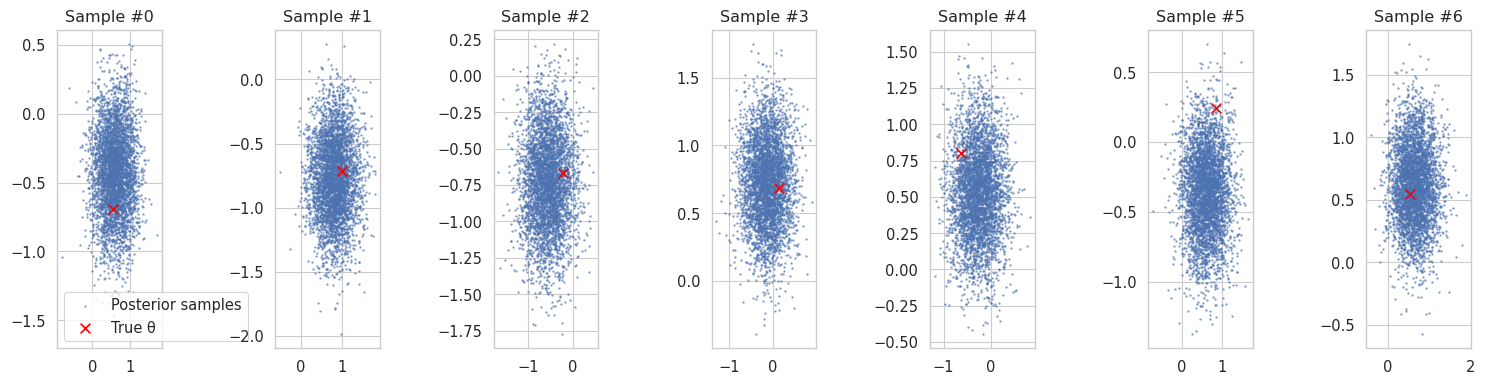

Checking if true parameters are covered by posteriors:
Sample 0: Covered: True
Sample 1: Covered: True
Sample 2: Covered: True
Sample 3: Covered: True
Sample 4: Covered: True
Sample 5: Covered: True
Sample 6: Covered: True


In [15]:
# Test with a few examples to verify correctness
n_test = 7

fig, axes = plt.subplots(1, n_test, figsize=(15, 4))

for i in range(n_test):
   axes[i].scatter(ref_posteriors[i, :, 0], ref_posteriors[i, :, 1], 
                  alpha=0.5, s=1, label='Posterior samples')
   axes[i].scatter(theta[i, 0], theta[i, 1], 
                  color='red', s=50, marker='x', label='True θ')
   axes[i].set_title(f'Sample #{i}')
   if i == 0:
       axes[i].legend()

plt.tight_layout()
# Save the figure
os.makedirs('toy-2-dim-figures', exist_ok=True)
filename = f'toy-2-dim-figures/example-samples.png'
plt.savefig(filename, dpi=300, bbox_inches='tight')
print(f"Saved plot: {filename}")
plt.show()


# Check if true parameters are within posterior support
print("Checking if true parameters are covered by posteriors:")
for i in range(min(n_test, n_simulations)):
   post_min = ref_posteriors[i].min(dim=0)[0]
   post_max = ref_posteriors[i].max(dim=0)[0]
   covered = torch.all((theta[i] >= post_min) & (theta[i] <= post_max))
   print(f"Sample {i}: Covered: {covered}")

**Compare parameter space coverage:** TailedUniform extends beyond [-1,1]² boundaries with Gaussian tails, while Uniform is strictly bounded.

Saved plot: toy-2-dim-figures/parameter-space.png


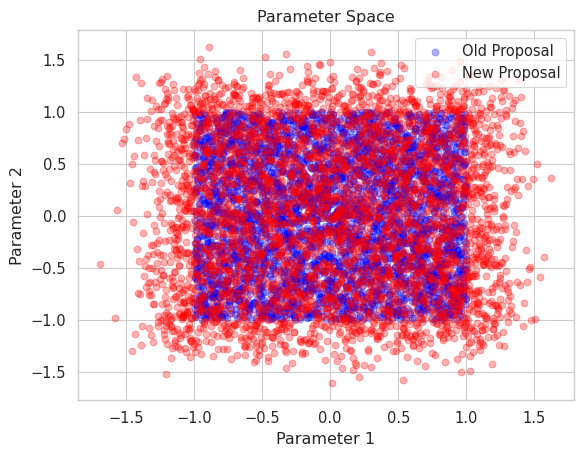

In [16]:
plt.scatter(theta_old[:, 0].cpu(), theta_old[:, 1].cpu(), c='blue', label='Old Proposal', alpha=0.3)
plt.scatter(theta[:, 0].cpu(), theta[:, 1].cpu(), c='red', label='New Proposal', alpha=0.3)
plt.xlabel('Parameter 1')
plt.ylabel('Parameter 2')
plt.title('Parameter Space')
plt.legend()

filename = f'toy-2-dim-figures/parameter-space.png'
plt.savefig(filename, dpi=300, bbox_inches='tight')
print(f"Saved plot: {filename}")

**Visualize marginal and joint distributions:** compare 1D marginals and 2D scatter plots showing TailedUniform's extended tail support.

Saved plot: toy-2-dim-figures/parameter-space-posterior.png


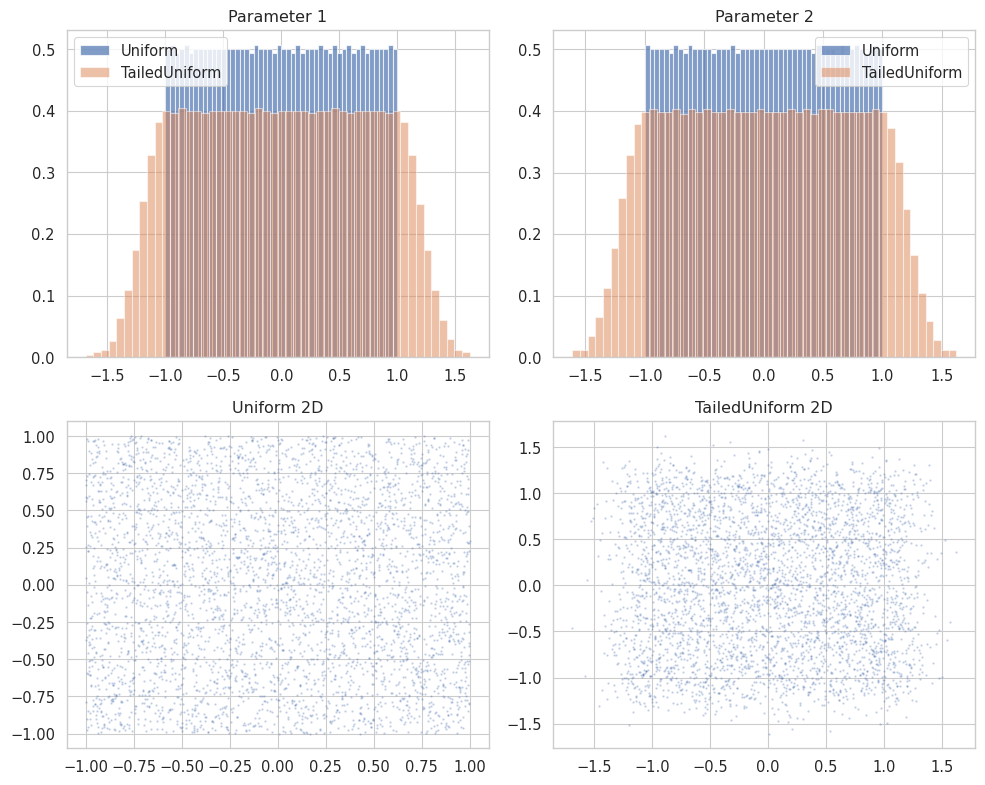

In [17]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

# Parameter 1
axes[0,0].hist(theta_old[:, 0], bins=50, alpha=0.7, label='Uniform', density=True)
axes[0,0].hist(theta[:, 0], bins=50, alpha=0.5, label='TailedUniform', density=True)
axes[0,0].set_title('Parameter 1')
axes[0,0].legend()

# Parameter 2
axes[0,1].hist(theta_old[:, 1], bins=50, alpha=0.7, label='Uniform', density=True)
axes[0,1].hist(theta[:, 1], bins=50, alpha=0.5, label='TailedUniform', density=True)
axes[0,1].set_title('Parameter 2')
axes[0,1].legend()

# 2D scatter plots
axes[1,0].scatter(theta_old[:, 0], theta_old[:, 1], alpha=0.2, s=1)
axes[1,0].set_title('Uniform 2D')

axes[1,1].scatter(theta[:, 0], theta[:, 1], alpha=0.2, s=1)
axes[1,1].set_title('TailedUniform 2D')

plt.tight_layout()

filename = f'toy-2-dim-figures/parameter-space-posterior.png'
plt.savefig(filename, bbox_inches='tight')
print(f"Saved plot: {filename}")

### Initialize NPE training setup

Create dataloaders and configure identical NPE ensembles (MAF+MADE) for both proposals with matching hyperparameters.

In [18]:
# Create dataloaders
loader_old = NumpyLoader(x=x_old, theta=theta_old)
loader = NumpyLoader(x=x, theta=theta)

# Instantiate neural networks for ensemble
nets = [
    ili.utils.load_nde_sbi(engine='NPE', model='maf', hidden_features=16, num_transforms=5,),
    ili.utils.load_nde_sbi(engine='NPE', model='made', hidden_features=16, num_transforms=5,)
]

# Define training arguments
train_args = {
    'training_batch_size': 64,
    'learning_rate': 5e-5
}

# Initialize the trainers
os.makedirs('toy-2-dim-models', exist_ok=True)
runner_old = InferenceRunner.load(
    backend='sbi',
    engine='NPE',
    prior=prior,
    nets=nets,
    device=device,
    train_args=train_args,
    proposal=proposal_old,
    out_dir='toy-2-dim-models/uniform'
)

runner = InferenceRunner.load(
    backend='sbi',
    engine='NPE',
    prior=prior,
    nets=nets,
    device=device,
    train_args=train_args,
    proposal=proposal_new,
    out_dir='toy-2-dim-models/taileduniform'
)

In [19]:
posterior_ensemble_old, summaries_old = runner_old(loader=loader_old)

INFO:root:MODEL INFERENCE CLASS: NPE
/home/x-ctirapongpra/.conda/envs/2024.02-py311/tailed-uniform/lib/python3.10/site-packages/sbi/inference/snpe/snpe_base.py:601: UserWarning: The proposal you passed is neither the prior nor a `NeuralPosterior` object. If you are an expert user and did so for research purposes, this is fine. If not, you might be doing something wrong: feel free to create an issue on Github.
  warn(
INFO:root:Training model 1 / 2.


Using SNPE-C with atomic loss
Using SNPE-C with atomic loss
 Training neural network. Epochs trained: 297

INFO:root:Training model 2 / 2.


 Neural network successfully converged after 298 epochs.Using SNPE-C with atomic loss
Using SNPE-C with atomic loss
 Neural network successfully converged after 72 epochs.

/home/x-ctirapongpra/.conda/envs/2024.02-py311/tailed-uniform/lib/python3.10/site-packages/sbi/utils/posterior_ensemble.py:142: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self._weights = torch.tensor(weights) / sum(weights)
INFO:root:It took 169.13104391098022 seconds to train models.
INFO:root:Saving model to toy-2-dim-models/uniform


In [20]:
posterior_ensemble, summaries = runner(loader=loader)

INFO:root:MODEL INFERENCE CLASS: NPE
INFO:root:Training model 1 / 2.


Using SNPE-C with atomic loss
Using SNPE-C with atomic loss
 Training neural network. Epochs trained: 144

INFO:root:Training model 2 / 2.


 Neural network successfully converged after 145 epochs.Using SNPE-C with atomic loss
Using SNPE-C with atomic loss
 Training neural network. Epochs trained: 54

INFO:root:It took 85.93386721611023 seconds to train models.
INFO:root:Saving model to toy-2-dim-models/taileduniform


 Neural network successfully converged after 55 epochs.

Plot training and validation log-probability to verify both models converged successfully.

Saved plot: toy-2-dim-figures/train-and-val.png


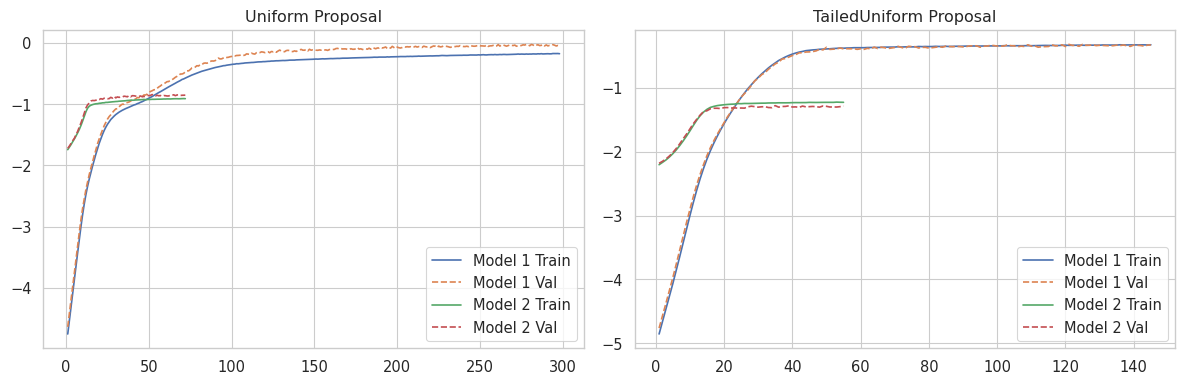

In [21]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Uniform proposal
for i, summary in enumerate(summaries_old):
   train_logprob = -1.0 * np.array(summary['training_loss'])
   val_logprob = -1.0 * np.array(summary['validation_loss'])
   epochs = np.arange(1, len(train_logprob) + 1)
   axes[0].plot(epochs, train_logprob, label=f"Model {i+1} Train")
   axes[0].plot(epochs, val_logprob, '--', label=f"Model {i+1} Val")
axes[0].set_title('Uniform Proposal')
axes[0].legend()

# TailedUniform proposal  
for i, summary in enumerate(summaries):
   train_logprob = -1.0 * np.array(summary['training_loss'])
   val_logprob = -1.0 * np.array(summary['validation_loss'])
   epochs = np.arange(1, len(train_logprob) + 1)
   axes[1].plot(epochs, train_logprob, label=f"Model {i+1} Train")
   axes[1].plot(epochs, val_logprob, '--', label=f"Model {i+1} Val")
axes[1].set_title('TailedUniform Proposal')
axes[1].legend()

plt.tight_layout()
filename = f'toy-2-dim-figures/train-and-val.png'
plt.savefig(filename, dpi=300, bbox_inches='tight')
print(f"Saved plot: {filename}")
plt.show()